In [1]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

# 15 MB
data_set_zip = "tasks_1-20_v1-2.tar.gz"

#Select "task 5"
train_set_file = "qa5_three-arg-relations_train.txt"
test_set_file = "qa5_three-arg-relations_test.txt"

train_set_post_file = "tasks_1-20_v1-2/en/"+train_set_file
test_set_post_file = "tasks_1-20_v1-2/en/"+test_set_file

Made using https://www.oreilly.com/ideas/question-answering-with-tensorflow

In [23]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import tarfile
import json 
import hashlib
import re
import itertools
import operator

In [3]:
try: from urllib.request import urlretrieve, urlopen
except ImportError: 
    from urllib import urlretrieve
    from urllib2 import urlopen
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)
if (not os.path.isfile(data_set_zip) and
    not (os.path.isfile(train_set_file) and os.path.isfile(test_set_file))):
    urlretrieve ("https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz", 
                 data_set_zip)

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the output file is already created, don't recreate
        If the output file does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return
def targz_unzip_single_file(zip_file_name, output_file_name, interior_relative_path):
    if not os.path.isfile(output_file_name):
        with tarfile.open(zip_file_name) as un_zipped:
            un_zipped.extract(interior_relative_path+output_file_name)    
unzip_single_file(glove_zip_file, glove_vectors_file)
targz_unzip_single_file(data_set_zip, train_set_file, "tasks_1-20_v1-2/en/")
targz_unzip_single_file(data_set_zip, test_set_file, "tasks_1-20_v1-2/en/")

In [6]:
# Deserialize GloVe vectors
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")
wvecs = []
for item in glove_wordmap.items():
    wvecs.append(item[1])
s = np.vstack(wvecs)

# Gather the distribution hyperparameters
v = np.var(s,0) 
m = np.mean(s,0) 
RS = np.random.RandomState()

def fill_unk(unk):
    global glove_wordmap
    glove_wordmap[unk] = RS.multivariate_normal(m,np.diag(v))
    return glove_wordmap[unk]

In [16]:
def sentence2sequence(sentence):
    """

    - Turns an input paragraph into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.

      TensorFlow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      TensorFlow provides. Normal Python suffices for this task.
    """
    tokens = sentence.strip('"(),-').lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
#         print token
        i = len(token)
        while len(token) > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
                continue
            else:
                i = i-1
#                 print token
            if i == 0:
                # word OOV
                # https://arxiv.org/pdf/1611.01436.pdf
                rows.append(fill_unk(token))
                words.append(token)
                break
    return np.array(rows), words

In [17]:
# print(sentence2sequence("Hello sir how are you? My name is Sopan."))

In [19]:
def contextualize(set_file):
    """
    Read in the dataset of questions and build question+answer -> context sets.
    Output is a list of data points, each of which is a 7-element tuple containing:
        The sentences in the context in vectorized form.
        The sentences in the context as a list of string tokens.
        The question in vectorized form.
        The question as a list of string tokens.
        The answer in vectorized form.
        The answer as a list of string tokens.
        A list of numbers for supporting statements, which is currently unused.
    """
    data = []
    context = []
    with open(set_file, "r") as train:
        for line in train:
            l, ine = tuple(line.split(" ", 1))
            # Split the line numbers from the sentences they refer to.
            if l is "1":
                # New contexts always start with 1, 
                # so this is a signal to reset the context.
                context = []
            if "\t" in ine: 
                # Tabs are the separator between questions and answers,
                # and are not present in context statements.
                question, answer, support = tuple(ine.split("\t"))
                data.append((tuple(zip(*context))+
                             sentence2sequence(question)+
                             sentence2sequence(answer)+
                             ([int(s) for s in support.split()],)))
                # Multiple questions may refer to the same context, so we don't reset it.
            else:
                # Context sentence.
                context.append(sentence2sequence(ine[:-1]))
    return data
train_data = contextualize(train_set_post_file)
test_data = contextualize(test_set_post_file)

In [34]:
final_train_data = []
def accumulate(iterable, func=operator.add):
    'Return running totals'
    # accumulate([1,2,3,4,5]) --> 1 3 6 10 15
    # accumulate([1,2,3,4,5], operator.mul) --> 1 2 6 24 120
    it = iter(iterable)
    try:
        total = next(it)
    except StopIteration:
        return
    yield total
    for element in it:
        total = func(total, element)
        yield total
def finalize(data):
    """
    Prepares data generated by contextualize() for use in the network.
    """
    final_data = []
    for cqas in train_data:
        contextvs, contextws, qvs, qws, avs, aws, spt = cqas
#         print cqas[0][0].shape

        lengths = accumulate(len(cvec) for cvec in contextvs)
        context_vec = np.concatenate(contextvs)
        context_words = sum(contextws,[])

        # Location markers for the beginnings of new sentences.
        sentence_ends = np.array(list(lengths)) 
        final_data.append((context_vec, sentence_ends, qvs, spt, context_words, cqas, avs, aws))
    return np.array(final_data)
final_train_data = finalize(train_data)   
final_test_data = finalize(test_data)

In [35]:
tf.reset_default_graph()

In [36]:
# Hyperparameters

# The number of dimensions used to store data passed between recurrent layers in the network.
recurrent_cell_size = 128

# The number of dimensions in our word vectorizations.
D = 50 

# How quickly the network learns. Too high, and we may run into numeric instability 
# or other issues.
learning_rate = 0.005

# Dropout probabilities. For a description of dropout and what these probabilities are, 
# see Entailment with TensorFlow.
input_p, output_p = 0.5, 0.5

# How many questions we train on at a time.
batch_size = 128

# Number of passes in episodic memory. We'll get to this later.
passes = 4

# Feed Forward layer sizes: the number of dimensions used to store data passed from feed-forward layers.
ff_hidden_size = 256

weight_decay = 0.00000001
# The strength of our regularization. Increase to encourage sparsity in episodic memory, 
# but makes training slower. Don't make this larger than leraning_rate.

training_iterations_count = 400000
# How many questions the network trains on each time it is trained. 
# Some questions are counted multiple times.

display_step = 100
# How many iterations of training occur before each validation check.

In [37]:
# Input Module

# Context: A [batch_size, maximum_context_length, word_vectorization_dimensions] tensor 
# that contains all the context information.
context = tf.placeholder(tf.float32, [None, None, D], "context")  
context_placeholder = context # I use context as a variable name later on

# input_sentence_endings: A [batch_size, maximum_sentence_count, 2] tensor that 
# contains the locations of the ends of sentences. 
input_sentence_endings = tf.placeholder(tf.int32, [None, None, 2], "sentence")

# recurrent_cell_size: the number of hidden units in recurrent layers.
input_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

# input_p: The probability of maintaining a specific hidden input unit.
# Likewise, output_p is the probability of maintaining a specific hidden output unit.
gru_drop = tf.contrib.rnn.DropoutWrapper(input_gru, input_p, output_p)

# dynamic_rnn also returns the final internal state. We don't need that, and can
# ignore the corresponding output (_). 
input_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, context, dtype=tf.float32, scope = "input_module")

# cs: the facts gathered from the context.
cs = tf.gather_nd(input_module_outputs, input_sentence_endings)
# to use every word as a fact, useful for tasks with one-sentence contexts
s = input_module_outputs

In [38]:
# Question Module

# query: A [batch_size, maximum_question_length, word_vectorization_dimensions] tensor 
#  that contains all of the questions.

query = tf.placeholder(tf.float32, [None, None, D], "query")

# input_query_lengths: A [batch_size, 2] tensor that contains question length information. 
# input_query_lengths[:,1] has the actual lengths; input_query_lengths[:,0] is a simple range() 
# so that it plays nice with gather_nd.
input_query_lengths = tf.placeholder(tf.int32, [None, 2], "query_lengths")

question_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, query, dtype=tf.float32, 
                                               scope = tf.VariableScope(True, "input_module"))

# q: the question states. A [batch_size, recurrent_cell_size] tensor.
q = tf.gather_nd(question_module_outputs, input_query_lengths)

In [39]:
# Episodic Memory

# make sure the current memory (i.e. the question vector) is broadcasted along the facts dimension
size = tf.stack([tf.constant(1),tf.shape(cs)[1], tf.constant(1)])
re_q = tf.tile(tf.reshape(q,[-1,1,recurrent_cell_size]),size)


# Final output for attention, needs to be 1 in order to create a mask
output_size = 1 

# Weights and biases
attend_init = tf.random_normal_initializer(stddev=0.1)
w_1 = tf.get_variable("attend_w1", [1,recurrent_cell_size*7, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
w_2 = tf.get_variable("attend_w2", [1,recurrent_cell_size, output_size], 
                      tf.float32, initializer = attend_init)

b_1 = tf.get_variable("attend_b1", [1, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
b_2 = tf.get_variable("attend_b2", [1, output_size], 
                      tf.float32, initializer = attend_init)

# Regulate all the weights and biases
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_2))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_2))

def attention(c, mem, existing_facts):
    """
    Custom attention mechanism.
    c: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor 
        that contains all the facts from the contexts.
    mem: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor that 
        contains the current memory. It should be the same memory for all facts for accurate results.
    existing_facts: A [batch_size, maximum_sentence_count, 1] tensor that 
        acts as a binary mask for which facts exist and which do not.

    """
    with tf.variable_scope("attending") as scope:
        # attending: The metrics by which we decide what to attend to.
        attending = tf.concat([c, mem, re_q, c * re_q,  c * mem, (c-re_q)**2, (c-mem)**2], 2)

        # m1: First layer of multiplied weights for the feed-forward network. 
        #     We tile the weights in order to manually broadcast, since tf.matmul does not
        #     automatically broadcast batch matrix multiplication as of TensorFlow 1.2.
        m1 = tf.matmul(attending * existing_facts, 
                       tf.tile(w_1, tf.stack([tf.shape(attending)[0],1,1]))) * existing_facts
        # bias_1: A masked version of the first feed-forward layer's bias
        #     over only existing facts.

        bias_1 = b_1 * existing_facts

        # tnhan: First nonlinearity. In the original paper, this is a tanh nonlinearity; 
        #        choosing relu was a design choice intended to avoid issues with 
        #        low gradient magnitude when the tanh returned values close to 1 or -1. 
        tnhan = tf.nn.relu(m1 + bias_1)

        # m2: Second layer of multiplied weights for the feed-forward network. 
        #     Still tiling weights for the same reason described in m1's comments.
        m2 = tf.matmul(tnhan, tf.tile(w_2, tf.stack([tf.shape(attending)[0],1,1])))

        # bias_2: A masked version of the second feed-forward layer's bias.
        bias_2 = b_2 * existing_facts

        # norm_m2: A normalized version of the second layer of weights, which is used 
        #     to help make sure the softmax nonlinearity doesn't saturate.
        norm_m2 = tf.nn.l2_normalize(m2 + bias_2, -1)

        # softmaxable: A hack in order to use sparse_softmax on an otherwise dense tensor. 
        #     We make norm_m2 a sparse tensor, then make it dense again after the operation.
        softmax_idx = tf.where(tf.not_equal(norm_m2, 0))[:,:-1]
        softmax_gather = tf.gather_nd(norm_m2[...,0], softmax_idx)
        softmax_shape = tf.shape(norm_m2, out_type=tf.int64)[:-1]
        softmaxable = tf.SparseTensor(softmax_idx, softmax_gather, softmax_shape)
        return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_softmax(softmaxable)),-1)

# facts_0s: a [batch_size, max_facts_length, 1] tensor 
#     whose values are 1 if the corresponding fact exists and 0 if not.
facts_0s = tf.cast(tf.count_nonzero(input_sentence_endings[:,:,-1:],-1,keep_dims=True),tf.float32)


with tf.variable_scope("Episodes") as scope:
    attention_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

    # memory: A list of all tensors that are the (current or past) memory state 
    #   of the attention mechanism.
    memory = [q]

    # attends: A list of all tensors that represent what the network attends to.
    attends = []
    for a in range(passes):
        # attention mask
        attend_to = attention(cs, tf.tile(tf.reshape(memory[-1],[-1,1,recurrent_cell_size]),size),
                              facts_0s)

        # Inverse attention mask, for what's retained in the state.
        retain = 1-attend_to

        # GRU pass over the facts, according to the attention mask.
        while_valid_index = (lambda state, index: index < tf.shape(cs)[1])
        update_state = (lambda state, index: (attend_to[:,index,:] * 
                                                 attention_gru(cs[:,index,:], state)[0] + 
                                                 retain[:,index,:] * state))
        # start loop with most recent memory and at the first index
        memory.append(tuple(tf.while_loop(while_valid_index,
                          (lambda state, index: (update_state(state,index),index+1)),
                           loop_vars = [memory[-1], 0]))[0]) 

        attends.append(attend_to)

        # Reuse variables so the GRU pass uses the same variables every pass.
        scope.reuse_variables()


In [40]:
# Answer Module

# a0: Final memory state. (Input to answer module)
a0 = tf.concat([memory[-1], q], -1)

# fc_init: Initializer for the final fully connected layer's weights.
fc_init = tf.random_normal_initializer(stddev=0.1) 

with tf.variable_scope("answer"):
    # w_answer: The final fully connected layer's weights.
    w_answer = tf.get_variable("weight", [recurrent_cell_size*2, D], 
                               tf.float32, initializer = fc_init)
    # Regulate the fully connected layer's weights
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(w_answer)) 

    # The regressed word. This isn't an actual word yet; 
    #    we still have to find the closest match.
    logit = tf.expand_dims(tf.matmul(a0, w_answer),1)

    # Make a mask over which words exist.
    with tf.variable_scope("ending"):
        all_ends = tf.reshape(input_sentence_endings, [-1,2])
        range_ends = tf.range(tf.shape(all_ends)[0])
        ends_indices = tf.stack([all_ends[:,0],range_ends], axis=1)
        ind = tf.reduce_max(tf.scatter_nd(ends_indices, all_ends[:,1],
                                          [tf.shape(q)[0], tf.shape(all_ends)[0]]),
                            axis=-1)
        range_ind = tf.range(tf.shape(ind)[0])
        mask_ends = tf.cast(tf.scatter_nd(tf.stack([ind, range_ind], axis=1), 
                                          tf.ones_like(range_ind), [tf.reduce_max(ind)+1, 
                                                                    tf.shape(ind)[0]]), bool)
        # A bit of a trick. With the locations of the ends of the mask (the last periods in 
        #  each of the contexts) as 1 and the rest as 0, we can scan with exclusive or 
        #  (starting from all 1). For each context in the batch, this will result in 1s 
        #  up until the marker (the location of that last period) and 0s afterwards.
        mask = tf.scan(tf.logical_xor,mask_ends, tf.ones_like(range_ind, dtype=bool))

    # We score each possible word inversely with their Euclidean distance to the regressed word.
    #  The highest score (lowest distance) will correspond to the selected word.
    logits = -tf.reduce_sum(tf.square(context*tf.transpose(tf.expand_dims(
                    tf.cast(mask, tf.float32),-1),[1,0,2]) - logit), axis=-1)

In [41]:
# Training

# gold_standard: The real answers.
gold_standard = tf.placeholder(tf.float32, [None, 1, D], "answer")
with tf.variable_scope('accuracy'):
    eq = tf.equal(context, gold_standard)
    corrbool = tf.reduce_all(eq,-1)
    logloc = tf.reduce_max(logits, -1, keep_dims = True)
    # locs: A boolean tensor that indicates where the score 
    #  matches the minimum score. This happens on multiple dimensions, 
    #  so in the off chance there's one or two indexes that match 
    #  we make sure it matches in all indexes.
    locs = tf.equal(logits, logloc)

    # correctsbool: A boolean tensor that indicates for which 
    #   words in the context the score always matches the minimum score.
    correctsbool = tf.reduce_any(tf.logical_and(locs, corrbool), -1)
    # corrects: A tensor that is simply correctsbool cast to floats.
    corrects = tf.where(correctsbool, tf.ones_like(correctsbool, dtype=tf.float32), 
                        tf.zeros_like(correctsbool,dtype=tf.float32))

    # corr: corrects, but for the right answer instead of our selected answer.
    corr = tf.where(corrbool, tf.ones_like(corrbool, dtype=tf.float32), 
                        tf.zeros_like(corrbool,dtype=tf.float32))
with tf.variable_scope("loss"):
    # Use sigmoid cross entropy as the base loss, 
    #  with our distances as the relative probabilities. There are
    #  multiple correct labels, for each location of the answer word within the context.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.l2_normalize(logits,-1),
                                                   labels = corr)

    # Add regularization losses, weighted by weight_decay.
    total_loss = tf.reduce_mean(loss) + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

# TensorFlow's default implementation of the Adam optimizer works. We can adjust more than 
#  just the learning rate, but it's not necessary to find a very good optimum.
optimizer = tf.train.AdamOptimizer(learning_rate)

# Once we have an optimizer, we ask it to minimize the loss 
#   in order to work towards the proper training.
opt_op = optimizer.minimize(total_loss)
# Initialize

In [42]:
# Initialize variables
init = tf.global_variables_initializer()

# Launch the TensorFlow session
sess = tf.Session()
sess.run(init)

In [43]:
def prep_batch(batch_data, more_data = False):
    """
        Prepare all the preproccessing that needs to be done on a batch-by-batch basis.
    """
    context_vec, sentence_ends, questionvs, spt, context_words, cqas, answervs, _ = zip(*batch_data)
    ends = list(sentence_ends)
    maxend = max(map(len, ends))
    aends = np.zeros((len(ends), maxend))
    for index, i in enumerate(ends):
        for indexj, x in enumerate(i):
            aends[index, indexj] = x-1
    new_ends = np.zeros(aends.shape+(2,))

    for index, x in np.ndenumerate(aends):
        new_ends[index+(0,)] = index[0]
        new_ends[index+(1,)] = x

    contexts = list(context_vec)
    max_context_length = max([len(x) for x in contexts])
    contextsize = list(np.array(contexts[0]).shape)
    contextsize[0] = max_context_length
    final_contexts = np.zeros([len(contexts)]+contextsize)

    contexts = [np.array(x) for x in contexts]
    for i, context in enumerate(contexts):
        final_contexts[i,0:len(context),:] = context
    max_query_length = max(len(x) for x in questionvs)
    querysize = list(np.array(questionvs[0]).shape)
    querysize[:1] = [len(questionvs),max_query_length]
    queries = np.zeros(querysize)
    querylengths = np.array(list(zip(range(len(questionvs)),[len(q)-1 for q in questionvs])))
    questions = [np.array(q) for q in questionvs]
    for i, question in enumerate(questions):
        queries[i,0:len(question),:] = question
    data = {context_placeholder: final_contexts, input_sentence_endings: new_ends, 
                            query:queries, input_query_lengths:querylengths, gold_standard: answervs}
    return (data, context_words, cqas) if more_data else data

In [44]:
# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass


# Prepare validation set
batch = np.random.randint(final_test_data.shape[0], size=batch_size*10)
batch_data = final_test_data[batch]

validation_set, val_context_words, val_cqas = prep_batch(batch_data, True)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
def train(iterations, batch_size):
    training_iterations = range(0,iterations,batch_size)
    if tqdm_installed:
        # Add a progress bar if TQDM is installed
        training_iterations = tqdm(training_iterations)

    wordz = []
    for j in training_iterations:

        batch = np.random.randint(final_train_data.shape[0], size=batch_size)
        batch_data = final_train_data[batch]

        sess.run([opt_op], feed_dict=prep_batch(batch_data))
        if (j/batch_size) % display_step == 0:

            # Calculate batch accuracy
            acc, ccs, tmp_loss, log, con, cor, loc  = sess.run([corrects, cs, total_loss, logit,
                                                                context_placeholder,corr, locs], 
                                                               feed_dict=validation_set)
            # Display results
            print("Iter " + str(j/batch_size) + ", Minibatch Loss= ",tmp_loss,
                  "Accuracy= ", np.mean(acc))
train(30000,batch_size) # Small amount of training for preliminary results

  0%|          | 1/235 [00:17<1:07:23, 17.28s/it]

('Iter 0, Minibatch Loss= ', 0.67294413, 'Accuracy= ', 0.0046875002)


 43%|████▎     | 101/235 [04:24<05:50,  2.62s/it]

('Iter 100, Minibatch Loss= ', 0.67279965, 'Accuracy= ', 0.36953124)


 86%|████████▌ | 201/235 [08:22<01:24,  2.50s/it]

('Iter 200, Minibatch Loss= ', 0.67277646, 'Accuracy= ', 0.44687501)


100%|██████████| 235/235 [09:42<00:00,  2.48s/it]


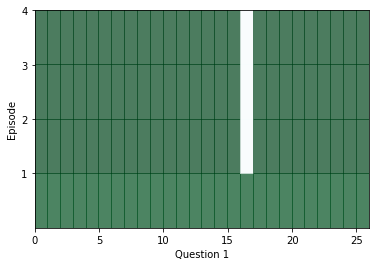

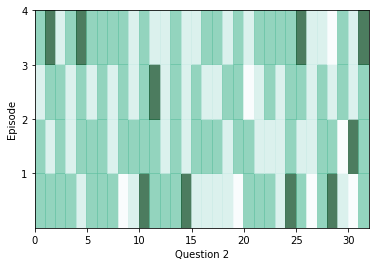

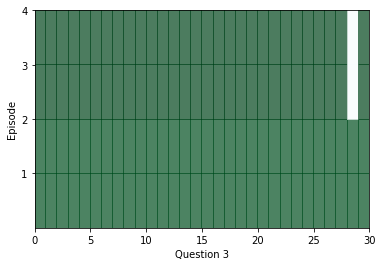

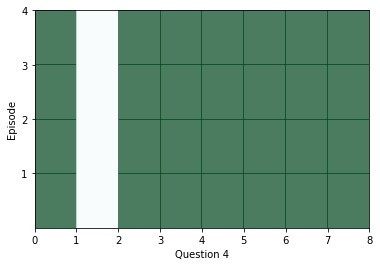

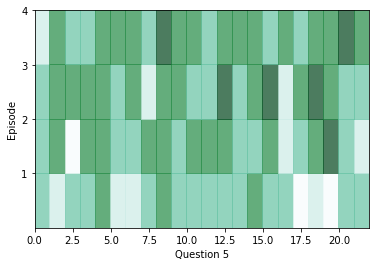

In [45]:
ancr = sess.run([corrbool,locs, total_loss, logits, facts_0s, w_1]+attends+
                [query, cs, question_module_outputs],feed_dict=validation_set)
a = ancr[0]
n = ancr[1]
cr = ancr[2]
attenders = np.array(ancr[6:-3]) 
faq = np.sum(ancr[4], axis=(-1,-2)) # Number of facts in each context

limit = 5
for question in range(min(limit, batch_size)):
    plt.yticks(range(passes,0,-1))
    plt.ylabel("Episode")
    plt.xlabel("Question "+str(question+1))
    pltdata = attenders[:,question,:int(faq[question]),0] 
    # Display only information about facts that actually exist, all others are 0
    pltdata = (pltdata - pltdata.mean()) / ((pltdata.max() - pltdata.min() + 0.001)) * 256
    plt.pcolor(pltdata, cmap=plt.cm.BuGn, alpha=0.7)
    plt.show()

#print(list(map((lambda x: x.shape),ancr[3:])), new_ends.shape)

In [46]:
# Locations of responses within contexts
indices = np.argmax(n,axis=1)

# Locations of actual answers within contexts 
indicesc = np.argmax(a,axis=1)

for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas))[:limit]:
    ccc = " ".join(cw)
    print("TEXT: ",ccc)
    print ("QUESTION: ", " ".join(cqa[3]))
    print ("RESPONSE: ", cw[i], ["Correct", "Incorrect"][i!=e])
    print("EXPECTED: ", cw[e])
    print()

('TEXT: ', 'bill went to the hallway . mary journeyed to the hallway . fred went to the garden . mary moved to the office . jeff went to the garden . bill grabbed the football there . jeff went back to the bedroom . bill left the football . bill grabbed the football there . mary went to the bedroom . bill went back to the office . fred travelled to the bathroom . mary went to the office . bill dropped the football there . mary went to the hallway . mary travelled to the garden . bill travelled to the kitchen . mary went to the bedroom . mary moved to the garden . fred grabbed the milk there . mary travelled to the hallway . fred went back to the bedroom . fred gave the milk to jeff . jeff handed the milk to fred . fred passed the milk to jeff . jeff handed the milk to fred .')
('QUESTION: ', 'who did jeff give the milk to ?')
('RESPONSE: ', 'fred', 'Correct')
('EXPECTED: ', 'fred')
()
('TEXT: ', 'bill travelled to the bathroom . bill moved to the hallway . bill journeyed to the office 